In [78]:
import pickle
import numpy as np
import osmnx as ox
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [79]:
def get_intercepted_routes(route_fugitive, tau_uv, results_positions):
    z_r = {}
    pi_nodes = []

    for u, value in enumerate(results_positions):
        # associated_node = labels_sorted_inv[int(u)][int(np.floor(value))]
        pi_nodes.append(results_positions[u])

    for i_r, _ in enumerate(route_fugitive):
        z_r[i_r] = 0

    for i_r, r in enumerate(route_fugitive):  # for each route
        if any([node in pi_nodes for node in r.values()]):
            for u, pi in enumerate(pi_nodes):  # for each police unit
                for time_at_node_fugitive, node_fugitive in r.items():  # for each node in the fugitive route
                    if node_fugitive == pi:  # if the fugitive node is the same as the target node of the police unit
                        if time_at_node_fugitive > tau_uv[u, node_fugitive]:  # and the police unit can reach that node
                            z_r[i_r] = 1  # intercepted

    return float(sum(z_r.values()))

In [80]:
iteration_dicts = [
    {'mode': 'randomwalk', 'noise': 0},
    {'mode': 'cool', 'noise': 0.02},
    {'mode': 'cool', 'noise': 0.05},
    {'mode': 'hot', 'noise': 0.05},
    {'mode': 'hot', 'noise': 0.1},
    # {'mode': 'hot+cool', 'noise': 0},  
]

In [81]:
# labels = ['random walk', 'cool, 2%', 'cool, 5%', 'hot, 5%', 'hot, 10%', 'superset']  
labels = ['random walk', 'cool, 2%', 'cool, 5%', 'hot, 5%', 'hot, 10%']  

In [82]:
city = 'Manhattan'
# mode = 'cool'
# jitter = 0.05

filepath = f"../graphs/{city}.graph.graphml"
G = ox.load_graphml(filepath=filepath)

In [83]:
scores = np.zeros((len(iteration_dicts), len(iteration_dicts)))

for j in range(len(iteration_dicts)):
    for i in range(len(iteration_dicts)):
        mode_opt = iteration_dicts[i]['mode']
        noise_opt = iteration_dicts[i]['noise']
        mode_eval = iteration_dicts[j]['mode']
        noise_eval = iteration_dicts[j]['noise']

        # import fugitive routes
        if mode_eval == 'hot+cool':
            results_routes = []
            with open(f'../data/results_routes_hot_{city}_jitter{0.05}.pkl', 'rb') as f:
                results_routes_hot = pickle.load(f)
                results_routes += results_routes_hot
            with open(f'../data/results_routes_hot_{city}_jitter{0.1}.pkl', 'rb') as f:
                results_routes_hot = pickle.load(f)
                results_routes += results_routes_hot
            with open(f'../data/results_routes_cool_{city}_jitter{0.02}.pkl', 'rb') as f:
                results_routes_cool = pickle.load(f)
                results_routes += results_routes_cool
            with open(f'../data/results_routes_cool_{city}_jitter{0.05}.pkl', 'rb') as f:
                results_routes_cool = pickle.load(f)
                results_routes += results_routes_cool
        elif mode_eval == 'randomwalk':
            with open(f'../data/results_routes_randomwalk_{city}.pkl', 'rb') as f:
                results_routes = pickle.load(f)
        else:
            with open(f'../data/results_routes_{mode_eval}_{city}_jitter{noise_eval}.pkl', 'rb') as f:
                results_routes = pickle.load(f)
                
        # import police routes
        with open(f'../data/optimization/start_police_{city}.pkl', 'rb') as f:
            police_start = pickle.load(f)
        with open(f'../data/optimization/delays_police_{city}.pkl', 'rb') as f:
            delays = pickle.load(f)
        if mode_opt == 'hot+cool':
            with open(f'../results/optimization/results_positions_{mode_opt}_{city}.pkl', 'rb') as f:
                police_end = pickle.load(f)
        elif mode_opt == 'randomwalk':
            with open(f'../results/optimization/results_positions_{mode_opt}_{city}.pkl', 'rb') as f:
                police_end = pickle.load(f)   
        else:
            with open(f'../results/optimization/results_positions_{mode_opt}_{city}_jitter{noise_opt}.pkl', 'rb') as f:
                police_end = pickle.load(f)
            
        # create tau_uv (only the part you need)
        # tau_uv = {u: ox.shortest_path_length(G, police_start[u], police_end[u]) for u, _ in enumerate(police_start)}
        tau_uv = {(u, police_end[u]): nx.shortest_path_length(G, police_start[u], police_end[u], weight='travel_time') + delays[u] for u, _ in enumerate(police_start)}
        
        score = get_intercepted_routes(results_routes, tau_uv, police_end)  
        if mode_opt == 'hot+cool' and mode_eval == 'cool' and noise_eval == 0.02:
            print(police_end)
        if i==j and mode_eval == 'cool' and noise_eval == 0.02:
            print(police_end)
            
        if mode_eval == 'hot+cool':
            score = score/4
        # i: opt model, j: eval model
        scores[i][j] = score
        
        # print(mode_opt, jitter_opt, '-', mode_eval, jitter_eval)
        # print(score)

[370924957, 42427494, 589101921, 42437678, 9611529610]


In [84]:
scores

array([[740.,   1.,  42., 141., 130.],
       [279., 953., 668., 907., 489.],
       [329., 674., 695., 654., 687.],
       [231., 911., 723., 903., 476.],
       [107., 435., 439., 373., 519.]])

In [85]:
for i in range(len(iteration_dicts)):
    row = scores[i]
    diag = scores[i][i]
    scores[i] = (scores[i]-diag)/diag

# with open(f'../results/optimization/results_optimization_hot+cool_{city}_jitter{0.05}.pkl', 'rb') as f:
#     results = pickle.load(f)
# score_hot_cool = results['pct_intercepted']
# scores[5] = (scores[5]-score_hot_cool)/score_hot_cool

scores

array([[ 0.        , -0.99864865, -0.94324324, -0.80945946, -0.82432432],
       [-0.70724029,  0.        , -0.29905561, -0.04826863, -0.48688353],
       [-0.52661871, -0.03021583,  0.        , -0.05899281, -0.01151079],
       [-0.74418605,  0.00885936, -0.19933555,  0.        , -0.47286822],
       [-0.7938343 , -0.16184971, -0.15414258, -0.28131021,  0.        ]])

In [86]:
# for i in range(len(iteration_dicts)):
#     col = scores[:,i]
#     diag = scores[i][i]
#     scores[:,i] = (scores[:,i]-diag)/diag
#     
# # with open(f'../results/optimization/results_optimization_hot+cool_{city}_jitter{0.05}.pkl', 'rb') as f:
# #     results = pickle.load(f)
# # score_hot_cool = results['pct_intercepted']
# # scores[5] = (scores[5]-score_hot_cool)/score_hot_cool
# 
# scores

In [87]:
scores[:,i]

array([-0.82432432, -0.48688353, -0.01151079, -0.47286822,  0.        ])

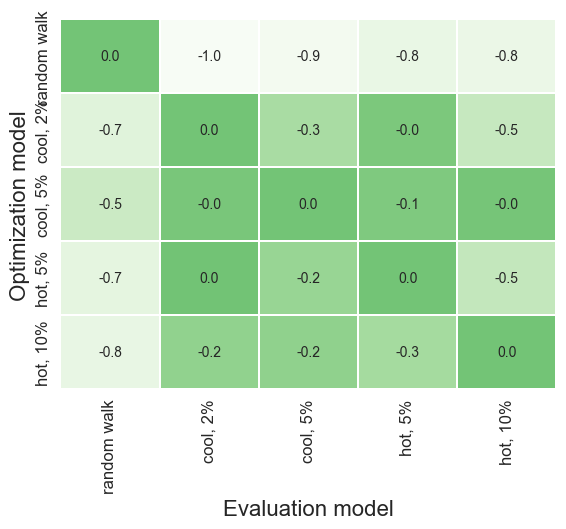

In [88]:
g = sns.heatmap(scores, cmap='Greens', annot=True, fmt=".1f", xticklabels=labels, yticklabels=labels, linewidths=0.05, center=0, cbar=False)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.ylabel('Optimization model', fontsize=16)
plt.xlabel('Evaluation model', fontsize=16)
plt.savefig(f'heatmap_{city}.png', bbox_inches='tight', dpi=300)

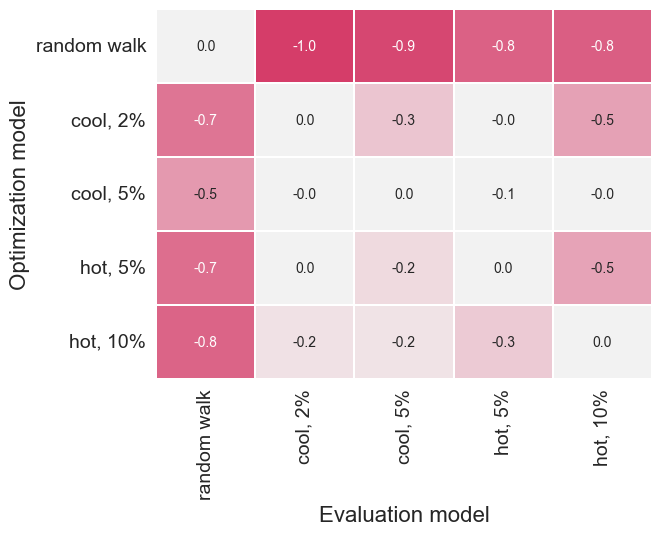

In [89]:
cmap = sns.diverging_palette(0, 255, sep=20, as_cmap=True)
# sns.set(font_scale=1.2)
sns.heatmap(scores, cmap=cmap, center=0, annot=True, fmt=".1f", xticklabels=labels, yticklabels=labels, linewidths=0.05, cbar=False)
plt.xticks(fontsize=14, rotation=90)  # 
plt.yticks(fontsize=14, rotation=0)
plt.ylabel('Optimization model', fontsize=16)
plt.xlabel('Evaluation model', fontsize=16)
plt.savefig(f'heatmap_{city}_divpalette.png', bbox_inches='tight', dpi=300)

In [90]:
# # cmap = sns.diverging_palette(0, 255, sep=8, as_cmap=True)
# sns.heatmap(scores, cmap="PRGn", center=-0.1, annot=True, fmt=".1f", xticklabels=labels, yticklabels=labels, linewidths=0.05, cbar=False)
# plt.ylabel('Optimization model')
# plt.xlabel('Evaluation model')
# plt.savefig(f'heatmap_{city}_divpalette.png', bbox_inches='tight', dpi=300)